In [59]:
from typing import TypedDict, List, Annotated
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv



In [60]:
load_dotenv()

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [61]:
class AgentState(TypedDict):
    task: str # keep track of the task (the human input or prompt
    plan: str # the plan that the planning agent will generate in the first step
    draft: str # draft of the easey
    critique: str # critic message - the critic agent will populate this key
    content: List[str] # list of document AI as research and returned
    revision_number: int # keep track of the number of revision made
    max_revisions: int # maximum number of revision to make
    


In [62]:
# defining the planning prompt
PLAN_PROMPT = """
You are an expert writer tasked with writing a high level outline of an essay. Write such an outline for the user provided topic.
Give an outline of the essay along with any relevant notes or instructions for the sections.
"""

# defining the prompt that will beused by the agents that's doing research after the planning step
# givein a plan, it will generate some queries and pass them to Tavily

RESEARCH_PLAN_PROMPT = """ 
You are a researcher charged with providing information that can be used whwn writing the following essay
Generate a list of search queires that will gather any relevant information. Only generate 3 queries max
"""

# Defining the Writer Prompt
WRITER_PROMPT ="""
You are an essay assistant tasked with writing excellent 5-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If theuser provides critique, respond with a reised version of your previous attempts.
Utilize all the information below as needed
---
{content}
"""

#Define the reflection prompt
REFLECTION_PROMPT = """
You are a teacher grading an essay submission .
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style etc
"""

# Defining the research Critique Prompt
RESEARCH_CRITIQUE_PROMPT = """
You are a researcher chargd with providing information that can be used when makinig any requested revisions (As outlined below).
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.
"""

In [63]:
from pydantic import BaseModel
from typing import List

class Queries(BaseModel):
    queries: List[str]

### import and instantiate Tavily

In [64]:
# from tavily import TavilyClient
# import os

# tavily = TavilyClient()

from langchain_community.tools.tavily_search import TavilySearchResults

# Initialize the tool (it reads the API key from the environment variable `TAVILY_API_KEY`)
tavily = TavilySearchResults()

### Implement the Agent and the Nodes

In [65]:
#creating the planning node

def plan_node(state:AgentState):
    message = [
        SystemMessage(content= PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(message)
    return {"plan":response.content}


In [66]:
# creating the research_pla_node
# It generates research queries based on a given task and retrieves relevant content usisng those queries

def research_plan_node(state:AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content = state['task'])
    ])

    content = state.get('content',[])
    for q in queries.queries:
        response =  tavily.invoke({"query":q, "max_results":2})
        for resp in response['results']:
            content.append(resp['content'])
    return {"content": content }

In [67]:
# creating the generation node

def generation_node(state:AgentState):
    content = "\n\n".join(state['content'] or [])

    user_message = HumanMessage(
        content = f"{state['task']}\n\nHere is my plan\n\n {state['plan']}"
    )

    messages = [
        SystemMessage(
            content= WRITER_PROMPT.format(content=content)
        ),
        user_message

    ]

    response = model.invoke(messages)

    return {
        "drafts": response.content,
        "revision_number": state.get("revision_number",1)+1
    }

In [68]:
# creating the reflection node

def reflection_node(state:AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invokes(messages)
    return {"critique": response.content}

In [69]:
# Creating the Search Critique node

def research_critique_node(state:AgentState):
    queries = model.with_structure_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state.get('content',[])
    for q in queries.queries:
        response =  tavily.invoke({"query":q, "max_results":2})
        for resp in response['results']:
            content.append(resp['content'])
    return {"content": content }

### Defining the Conditional Edge

In [70]:
# Defining the conditional Edge

def should_continue(state:AgentState):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'
    

### Defining the Graph

In [71]:
graph = StateGraph(AgentState)

#adding node to the graph
graph.add_node('planner', plan_node)
graph.add_node('generate', generation_node)
graph.add_node('reflect', reflection_node)
graph.add_node('research_plan', research_plan_node)
graph.add_node('research_critique', research_critique_node)

graph.set_entry_point('planner')

#adding the conditional edge
graph.add_conditional_edges(
    "generate",
    should_continue,
    {END:END, "reflect": "reflect"}
     )
# adding regula edges
graph.add_edge('planner','research_plan')
graph.add_edge('research_plan','generate')
graph.add_edge('reflect','research_critique')
graph.add_edge('research_critique','generate')

In [72]:
# from langgraph.checkpoint.sqlite_saver import SqliteSaver
# from langgraph.checkpoint.memory import MemorySaver

# # Option 1: Using in-memory SQLite checkpointing
# memory = SqliteSaver.from_conn_str(":memory:")
# graph = graph.compile(checkpointer=memory)

# Option 2: Using simple in-memory (RAM-based) checkpointing
# memory = MemorySaver()
# graph = graph.compile(checkpointer=memory)


from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph.compile(checkpointer=memory)

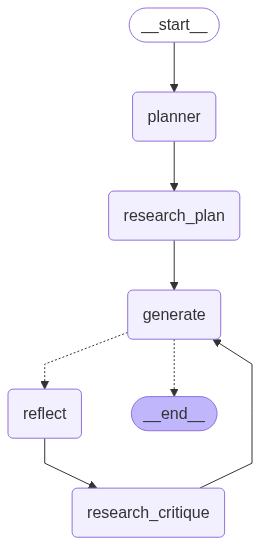

In [73]:
graph

### Running the Agentic App

In [74]:
thread = {'configurable':{'thread_id':'1'}}
task = 'write an essay about Reflection vs. Reflextion in Langraph'

prompt = {
    'task': task,
    'max_revision':2,
    'revision_number':1,
}

events = graph.stream(prompt, thread)

for e in events:
    print(e)
    print('=',130)


{'planner': {'plan': "**Essay Outline: Reflection vs. Reflextion in Langraph**\n\n**I. Introduction**\n   A. Definition of key terms\n      1. Reflection: The process of introspection and consideration of one's thoughts, feelings, and experiences.\n      2. Reflextion: A term coined within the context of Langraph, representing a unique perspective or interpretation of reflection.\n   B. Importance of the topic\n      1. Understanding the nuances between reflection and reflextion can enhance personal growth and communication.\n      2. Relevance in various fields such as psychology, education, and interpersonal relationships.\n   C. Thesis statement\n      1. This essay will explore the distinctions between reflection and reflextion in Langraph, their implications for personal development, and their applications in real-world scenarios.\n\n**II. Historical Context of Reflection in Langraph**\n   A. Origins of the concept of reflection\n      1. Philosophical roots (e.g., Socratic method

TypeError: list indices must be integers or slices, not str